In [1]:
import os
import sys
import glob
import pickle
from time import strftime, localtime

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_transform as tft

import matplotlib.pyplot as plt
plt.rc('font', **{'family': 'sans-serif', 'size': 9})

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

%matplotlib inline

In [4]:
def plot_data(data_folder, gen_id, H_values = [2,10], xlim_distr = None):
    H_values = np.array(H_values)
    var_names = (f'omega_G{gen_id}', f'Pe_G{gen_id}')
    n_vars = len(var_names)
    inertia = {'training': H_values}
    time, x, y = load_data(data_folder, gen_id, inertia, var_names)

    x_train_mean = np.mean(x['training'], axis=(1,2))
    x_train_std = np.std(x['training'], axis=(1,2))
    x['training'] = tf.constant([(x['training'][i].numpy() - m) / s \
                                 for i,(m,s) in enumerate(zip(x_train_mean, x_train_std))])
    
    fig = plt.figure(figsize=(7,4))
    gs = fig.add_gridspec(2, 3)
    ax = [
        fig.add_subplot(gs[0,:2]),
        fig.add_subplot(gs[1,:2]),
        fig.add_subplot(gs[0,2]),
        fig.add_subplot(gs[1,2])
    ]

    idx_min, _ = np.where(y['training'] == H_values.min())
    idx_max, _ = np.where(y['training'] == H_values.max())

    if xlim_distr is not None:
        lim = xlim_distr
    else:
        lim = 0
    for i in range(2):
        ax[i].plot(time, x['training'].numpy()[i, idx_min[:5], :].T, 'k', lw=1)
        ax[i].plot(time, x['training'].numpy()[i, idx_max[:5], :].T, 'r', lw=1)

        n,edges = np.histogram(np.ndarray.flatten(x['training'][i,:,:].numpy()[idx_min,:]), \
                               bins=100, range=[-4,4], density=True)
        lim = n.max() if n.max() > lim else lim
        ax[i+2].plot(n, edges[:-1], 'k', linewidth=1.2, label=f'H={H_values[0]:g}')
        n,edges = np.histogram(np.ndarray.flatten(x['training'][i,:,:].numpy()[idx_max,:]), \
                               bins=100, range=[-4,4], density=True)
        lim = n.max() if n.max() > lim else lim
        ax[i+2].plot(n, edges[:-1], 'r', linewidth=1.2, label=f'H={H_values[1]:g}')
        ax[i+2].set_yticklabels([])
    ax[2].plot([0, lim*1.05], [0,0], '--', lw=1, color=[.6,.6,.6])
    ax[3].plot([0, lim*1.05], [0,0], '--', lw=1, color=[.6,.6,.6])

    for a in ax:
        for side in 'right', 'top':
            a.spines[side].set_visible(False)

    ax[0].get_shared_x_axes().join(ax[0], ax[1])
    ax[2].get_shared_x_axes().join(ax[2], ax[3])
    ax[0].get_shared_y_axes().join(ax[0], ax[2])
    ax[1].get_shared_y_axes().join(ax[1], ax[3])

    ax[0].set_ylabel(r'$\omega_{\mathrm{G}_%d}$ [Hz]' % gen_id)
    ax[1].set_ylabel(r'Pe$_{\mathrm{G}_%d}$ [Hz]' % gen_id)
    ax[1].set_xlabel('Time [s]')
    ax[3].set_xlabel('Fraction')
    ax[3].legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(data_folder + f'/generator_{gen_id}.pdf');

In [6]:
data_folder = '../data/IEEE14/var_H_G1/IEEE14_D=2_DZA=60.0/'
for gen_id in 1,2,3,6,8:
    plot_data(data_folder, [gen_id], xlim_distr = 0.67)

OSError: ``./H_2.000_training_set.h5`` does not exist

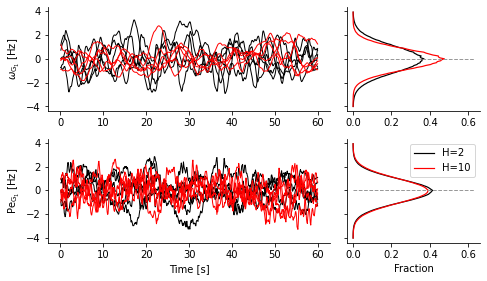

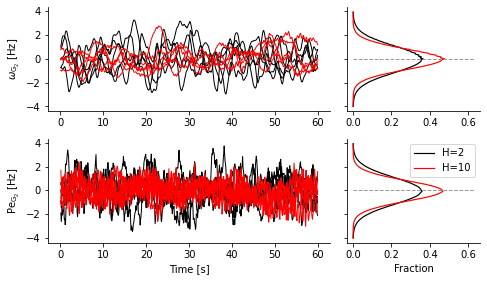

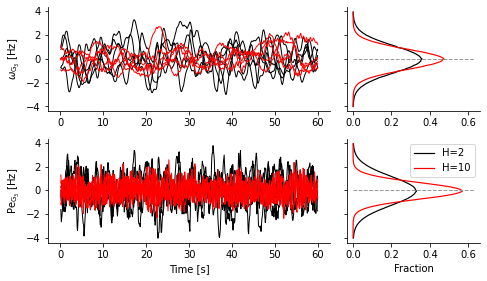

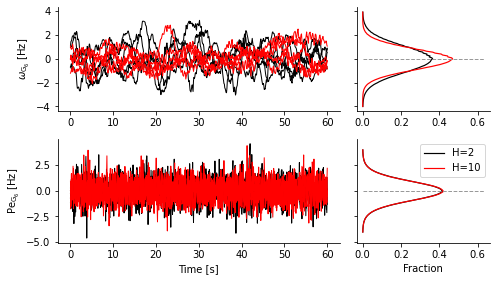

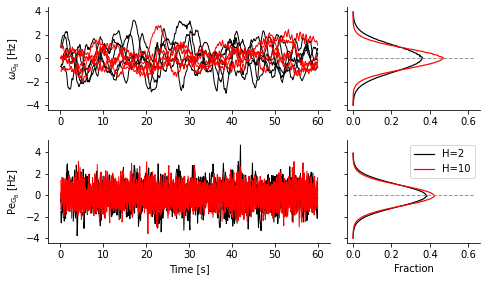

In [6]:
data_folder = '../data/var_H_G1/IEEE14_D=2_DZA=0.036/'
for gen_id in 1,2,3,6,8:
    plot_data(data_folder, gen_id, xlim_distr = 0.6)

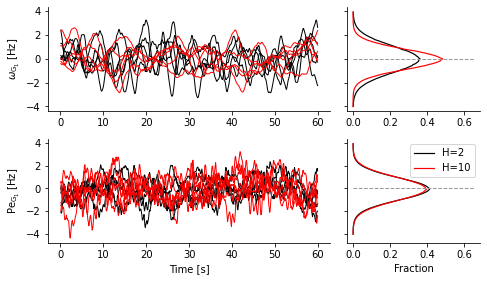

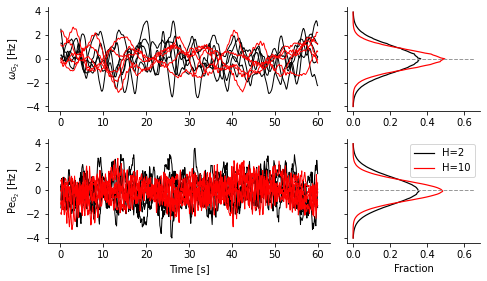

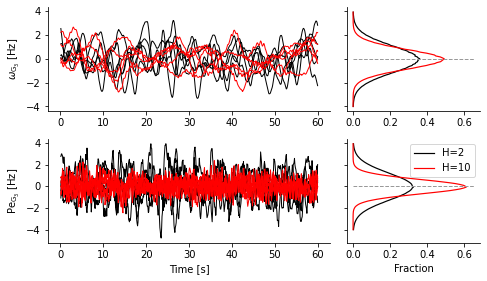

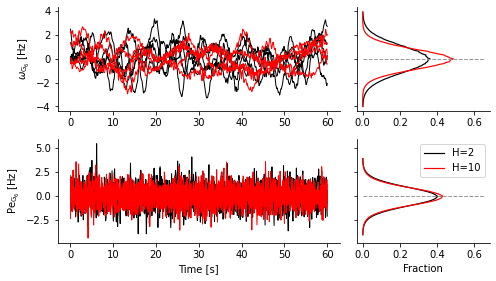

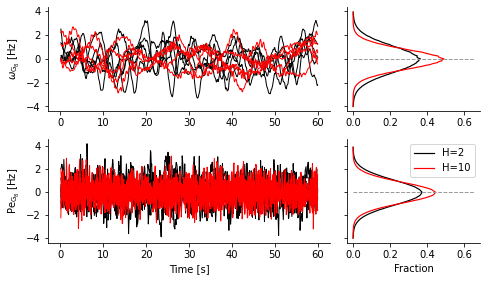

In [7]:
data_folder = '../data/var_H_G1/IEEE14_D=0_DZA=0.36/'
for gen_id in 1,2,3,6,8:
    plot_data(data_folder, gen_id, xlim_distr = 0.62)

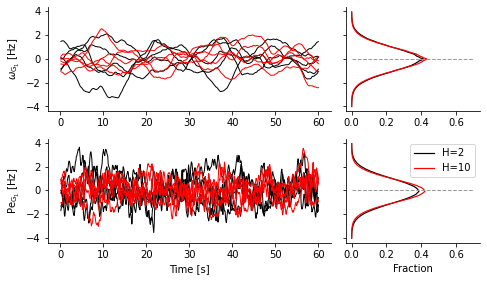

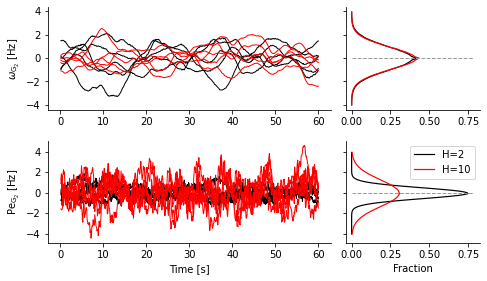

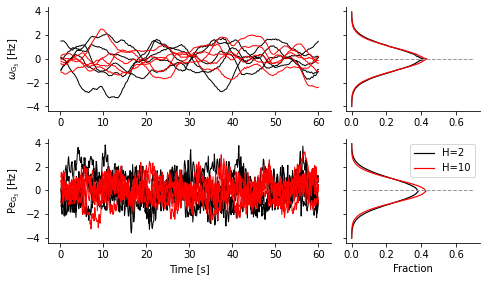

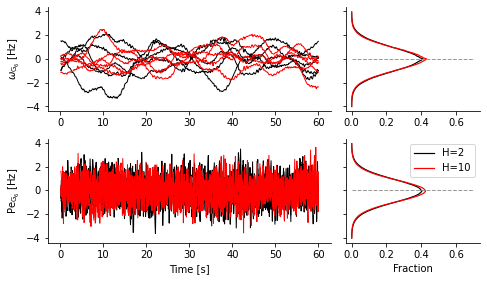

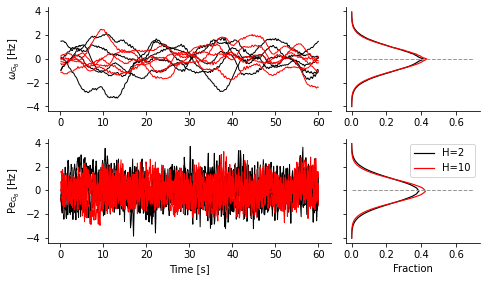

In [3]:
data_folder = '../data/var_H_G2/IEEE14_D=2_DZA=60.0/'
for gen_id in 1,2,3,6,8:
    plot_data(data_folder, gen_id, xlim_distr = 0.67)